<a href="https://colab.research.google.com/github/Omkar2499/Dataset/blob/main/Collected_Images_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir data

In [2]:
!unzip -qq final_dry_100.zip -d /content/data

In [3]:
!unzip -qq snowy-resized.zip -d /content/data/final_dry_100

In [4]:
!unzip -qq wet_subcategory_100_images.zip -d /content/data/final_dry_100

In [16]:
!mkdir dataset

In [22]:
!mv /content/data/final_dry_100/snowy-resized/dry_mud /content/dataset

In [ ]:
!mv /content/data/final_dry_100/snowy-resized/asphalt_dry /content/dataset

In [19]:
!mv /content/data/final_dry_100/snowy-resized/gravel_dry /content/dataset

In [14]:
!mv /content/dataset /content/data/final_dry_100/snowy-resized/snowy-resized/

In [23]:
!mkdir snowy-resized

In [24]:
!mv /content/data/final_dry_100/snowy-resized/snowy-resized/* /content/snowy-resized

In [25]:
!mv /content/data/final_dry_100/wet_subcategory_100_images/* /content/dataset

In [28]:
!mv /content/snowy-resized/* /content/dataset

mv: cannot stat '/content/snowy-resized/*': No such file or directory


In [31]:
import os

directory_path = "/content/dataset"
folder_names = [f"{folder_name}" for folder_name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder_name))]

print(folder_names)

print(len(folder_names))



['Muddy_wet', 'Packed_Snow', 'Heavy_Snow', 'asphalt_dry', 'Black_Ice', 'cobblestone_dry', 'dry_mud', 'Cobblestone_wet', 'Light_Snow', 'Asphalt_wet', 'Gravel_wet', 'Refrozen_Ice', 'concrete_dry', 'Slush', 'Concrete_wet', 'Sleet', 'Heavy_wet', 'gravel_dry']
18


In [32]:
import tensorflow as tf

import os

import shutil

import numpy as np

from sklearn.model_selection import train_test_split

classes = ['Muddy_wet', 'Packed_Snow', 'Heavy_Snow', 'asphalt_dry', 'Black_Ice', 'cobblestone_dry', 'dry_mud', 'Cobblestone_wet', 'Light_Snow', 'Asphalt_wet', 'Gravel_wet', 'Refrozen_Ice', 'concrete_dry', 'Slush', 'Concrete_wet', 'Sleet', 'Heavy_wet', 'gravel_dry']


data_dir = '/content/dataset'

train_dir = '/content/train'

test_dir = '/content/test'

# Create train and test directories

os.makedirs(train_dir, exist_ok=True)

os.makedirs(test_dir, exist_ok=True)

for cls in classes:

    # Create class-specific train and test directories

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)

    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Get a list of all image files for this class

    image_files = os.listdir(os.path.join(data_dir, cls))

    # Split the files into train and test sets

    train_files, test_files = train_test_split(image_files, test_size=0.3, random_state=42)  # 80% train, 20% test

    # Copy the train files into the train directory

    for file in train_files:

        shutil.copy(os.path.join(data_dir, cls, file), os.path.join(train_dir, cls, file))

    # Copy the test files into the test directory

    for file in test_files:

        shutil.copy(os.path.join(data_dir, cls, file), os.path.join(test_dir, cls, file))

In [33]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.optimizers import Adam

import scipy

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define the data generators

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(

    '/content/train',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(

    '/content/test',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical')

Found 1242 images belonging to 18 classes.
Found 533 images belonging to 18 classes.


In [34]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model

headModel = baseModel.output

headModel = Flatten(name="flatten")(headModel)

headModel = Dense(512, activation="relu")(headModel)

headModel = Dense(18, activation="softmax")(headModel)  # Change the number here according to your number of classes

# Place the head FC model on top of the base model (this will become the actual model we will train)

model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process

for layer in baseModel.layers:

    layer.trainable = False

# Compile the model

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [47]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model

headModel = baseModel.output

headModel = Flatten(name="flatten")(headModel)

headModel = Dense(1024, activation="relu")(headModel)

headModel = Dense(18, activation="softmax")(headModel)  # Change the number here according to your number of classes

# Place the head FC model on top of the base model (this will become the actual model we will train)

model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process

for layer in baseModel.layers:

    layer.trainable = False

# Compile the model

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model_1024.keras', save_best_only=True, monitor='val_loss')

model.fit(train_generator, validation_data=test_generator, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - accuracy: 0.1736 - loss: 2.7856 - val_accuracy: 0.5478 - val_loss: 2.1218
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 422ms/step - accuracy: 0.6503 - loss: 1.8953 - val_accuracy: 0.6548 - val_loss: 1.6068
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.7225 - loss: 1.4038 - val_accuracy: 0.7111 - val_loss: 1.2980
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.8170 - loss: 1.0429 - val_accuracy: 0.7392 - val_loss: 1.1184
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 565ms/step - accuracy: 0.8301 - loss: 0.8717 - val_accuracy: 0.7280 - val_loss: 1.0062
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.8659 - loss: 0.7050 - val_accuracy: 0.7505 - val_loss: 0.9272
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.8885 - loss: 0.6007 - val_accuracy: 0.7655 - val_loss: 0.8650
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.9271 - loss: 0.4640 - val_accu

In [45]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 53,279,096 (203.24 MB)

 Trainable params: 12,854,802 (49.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 25,709,606 (98.07 MB)

Found 533 images belonging to 18 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step


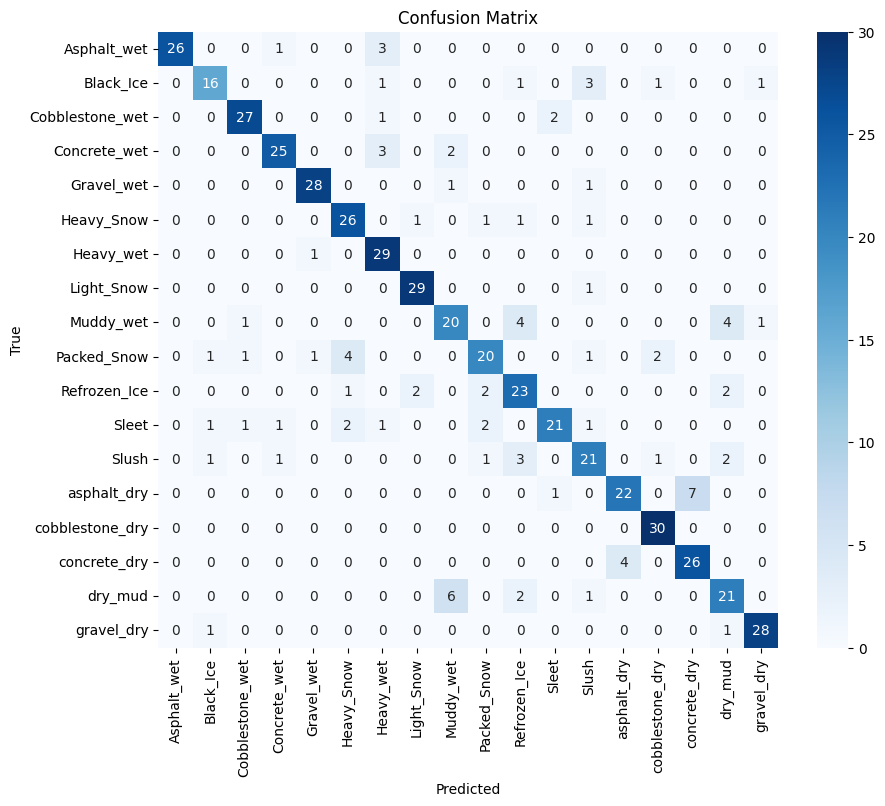

                 precision    recall  f1-score   support

    Asphalt_wet       1.00      0.87      0.93        30
      Black_Ice       0.80      0.70      0.74        23
Cobblestone_wet       0.90      0.90      0.90        30
   Concrete_wet       0.89      0.83      0.86        30
     Gravel_wet       0.93      0.93      0.93        30
     Heavy_Snow       0.79      0.87      0.83        30
      Heavy_wet       0.76      0.97      0.85        30
     Light_Snow       0.91      0.97      0.94        30
      Muddy_wet       0.69      0.67      0.68        30
    Packed_Snow       0.77      0.67      0.71        30
   Refrozen_Ice       0.68      0.77      0.72        30
          Sleet       0.88      0.70      0.78        30
          Slush       0.70      0.70      0.70        30
    asphalt_dry       0.85      0.73      0.79        30
cobblestone_dry       0.88      1.00      0.94        30
   concrete_dry       0.79      0.87      0.83        30
        dry_mud       0.70    

In [49]:
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# Load the trained model

model = tf.keras.models.load_model('best_model.keras')

# Load the test data

test_generator = test_datagen.flow_from_directory(

    '/content/test',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical',

    shuffle=False)

# Make predictions

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.title('Confusion Matrix')

plt.show()

# Print classification report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Found 533 images belonging to 18 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


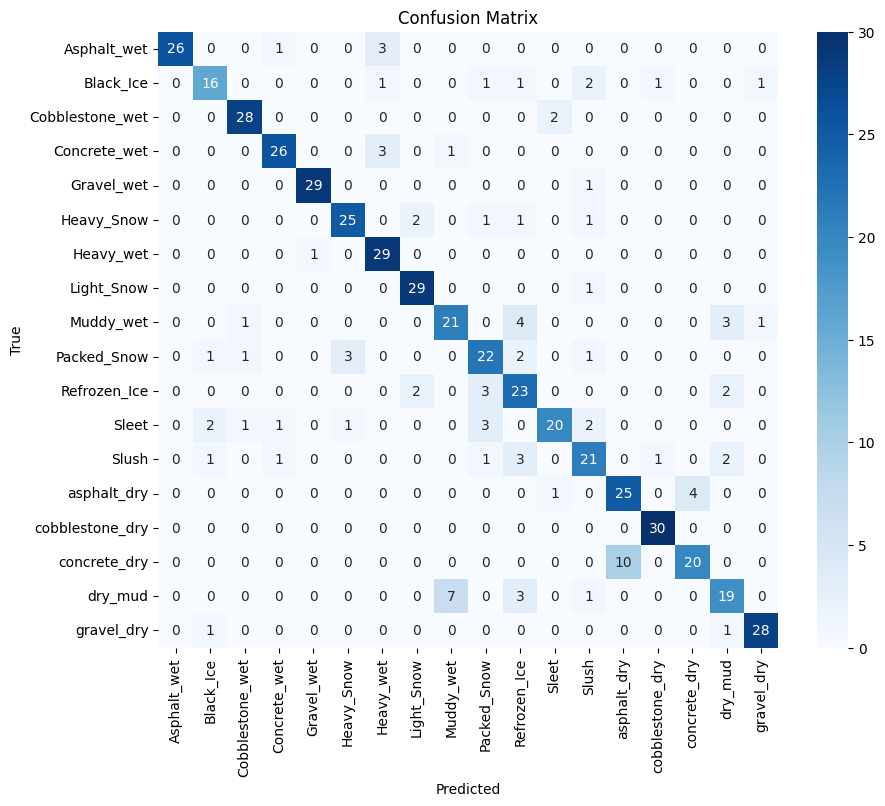

                 precision    recall  f1-score   support

    Asphalt_wet       1.00      0.87      0.93        30
      Black_Ice       0.76      0.70      0.73        23
Cobblestone_wet       0.90      0.93      0.92        30
   Concrete_wet       0.90      0.87      0.88        30
     Gravel_wet       0.97      0.97      0.97        30
     Heavy_Snow       0.86      0.83      0.85        30
      Heavy_wet       0.81      0.97      0.88        30
     Light_Snow       0.88      0.97      0.92        30
      Muddy_wet       0.72      0.70      0.71        30
    Packed_Snow       0.71      0.73      0.72        30
   Refrozen_Ice       0.62      0.77      0.69        30
          Sleet       0.87      0.67      0.75        30
          Slush       0.70      0.70      0.70        30
    asphalt_dry       0.71      0.83      0.77        30
cobblestone_dry       0.94      1.00      0.97        30
   concrete_dry       0.83      0.67      0.74        30
        dry_mud       0.70    

In [37]:
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# Load the trained model

model = tf.keras.models.load_model('best_model.keras')

# Load the test data

test_generator = test_datagen.flow_from_directory(

    '/content/test',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical',

    shuffle=False)

# Make predictions

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.title('Confusion Matrix')

plt.show()

# Print classification report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [40]:
import os

directory_path = "/content/dataset"
folder_names = [f"{folder_name}" for folder_name in sorted(os.listdir(directory_path), key=str.lower) if os.path.isdir(os.path.join(directory_path, folder_name))]

print(folder_names)


['asphalt_dry', 'Asphalt_wet', 'Black_Ice', 'cobblestone_dry', 'Cobblestone_wet', 'concrete_dry', 'Concrete_wet', 'dry_mud', 'gravel_dry', 'Gravel_wet', 'Heavy_Snow', 'Heavy_wet', 'Light_Snow', 'Muddy_wet', 'Packed_Snow', 'Refrozen_Ice', 'Sleet', 'Slush']


In [44]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the Keras model
model = load_model('/content/best_model.keras')

# Load the video file
video_capture = cv2.VideoCapture('/content/dashcam_1.mp4')

# Define the class names
#class_names = ['asphalt_dry', 'Asphalt_wet', 'Black_Ice', 'cobblestone_dry', 'Cobblestone_wet', 'concrete_dry', 'Concrete_wet', 'dry_mud', 'gravel_dry', 'Gravel_wet', 'Heavy_Snow', 'Heavy_wet', 'Light_Snow', 'Muddy_wet', 'Packed_Snow', 'Refrozen_Ice', 'Sleet', 'Slush']

class_names = ['Asphalt_wet', 'Black_Ice','Cobblestone_wet','Concrete_wet','Gravel_wet','Heavy_Snow','Heavy_wet','Light_Snow','Muddy_wet','Packed_Snow','Refrozen_Ice',
               'Sleet','Slush','asphalt_dry','cobblestone_dry','concrete_dry','dry_mud','gravel_dry']

# Define the FPS and duration per image
fps = 1  # frames per second
duration = 1  # seconds per image

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video_path = '/content/output_with_predictions.mp4'
output_video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    # Make predictions on the frame
    resized_frame = cv2.resize(frame, (224,224))
    normalized_frame = resized_frame / 255.0
    frame_array = np.array([normalized_frame])
    predictions = model.predict(frame_array)
    class_id = np.argmax(predictions, axis=1)

    # Get the class name
    class_name = class_names[class_id[0]]

    # Create text to be displayed on the frame
    road_surface_text = f"Road surface at each wheel (Wfl, Wrl, Wfr, Wrr): [{class_name}, {class_name}, {class_name}, {class_name}]"
    # split_mu_text = f"Split Mu of Road Classification at each wheel (Wfl, Wrl, Wfr, Wrr): [TBD, TBD, TBD, TBD]"
    surface_friction_text = f"Surface Friction at each wheel (Wfl, Wrl, Wfr, Wrr): [TBD, TBD, TBD, TBD]"

    # Draw the text on the frame
    cv2.rectangle(frame, (10, 10), (frame.shape[1] - 10, 100), (255, 255, 255), -1)
    cv2.putText(frame, road_surface_text, (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    # cv2.putText(frame, split_mu_text, (15, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, surface_friction_text, (15, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Write the output to the video file
    for _ in range(duration * fps):
        output_video_writer.write(frame)

# Release the video capture and output video writer
video_capture.release()
output_video_writer.release()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

Found 533 images belonging to 18 classes.
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


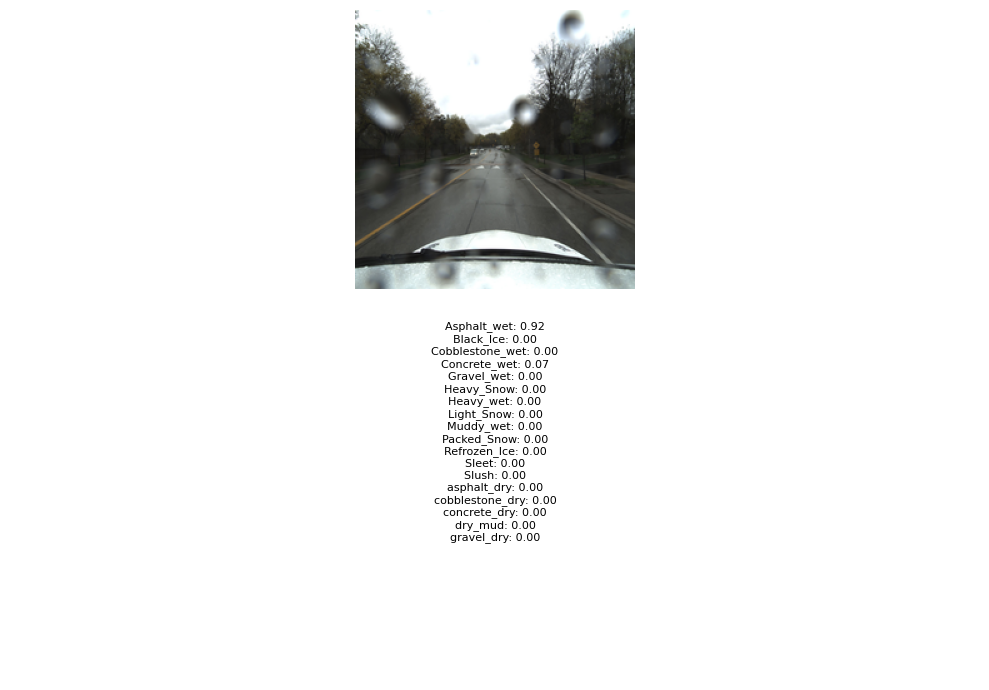

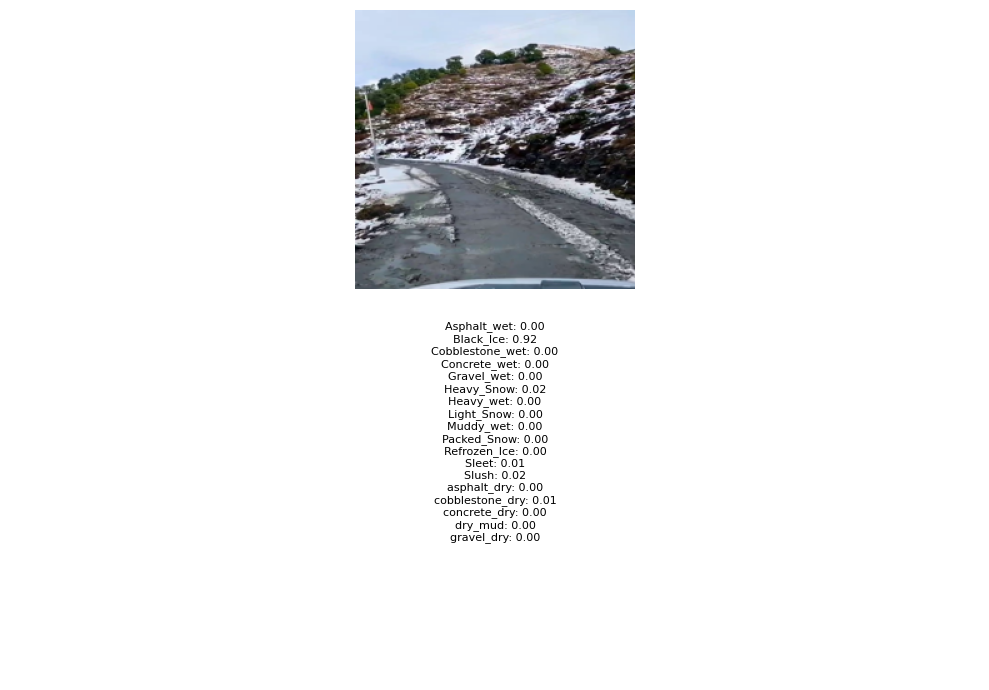

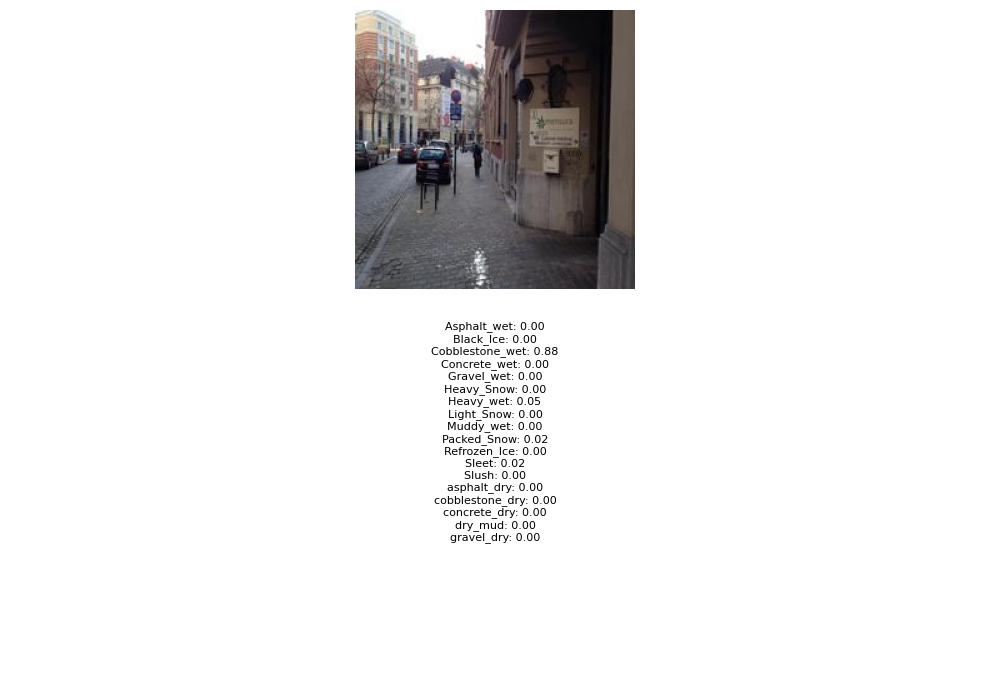

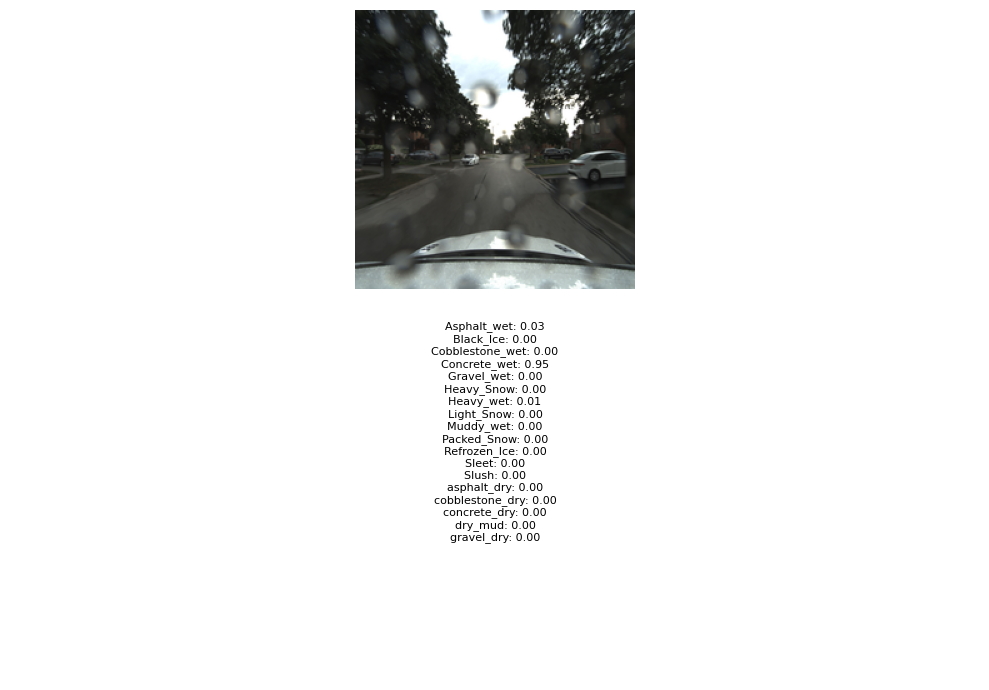

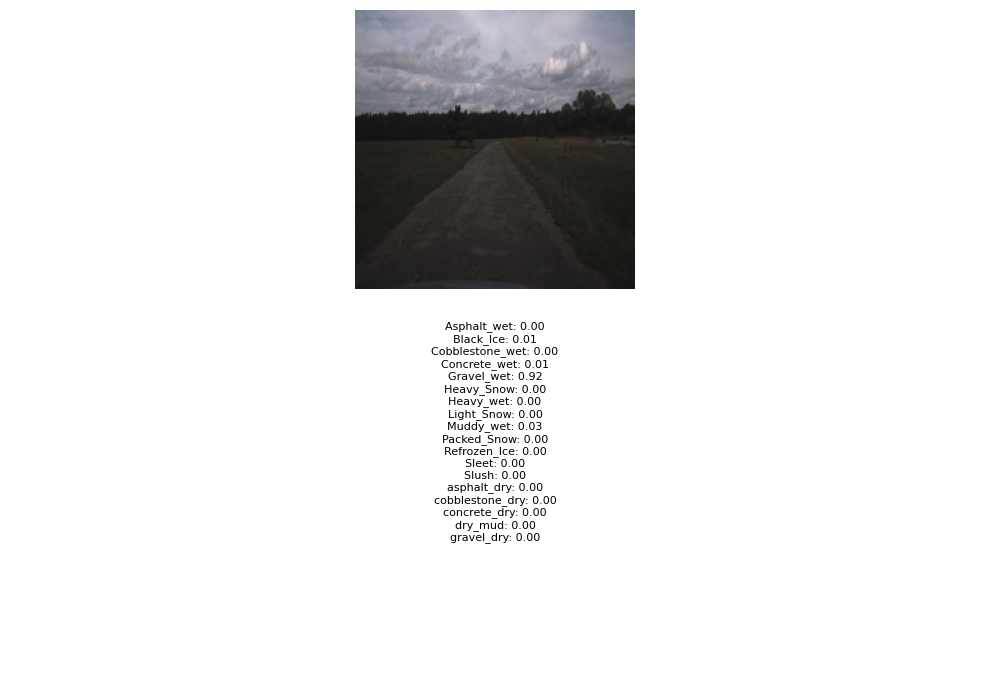

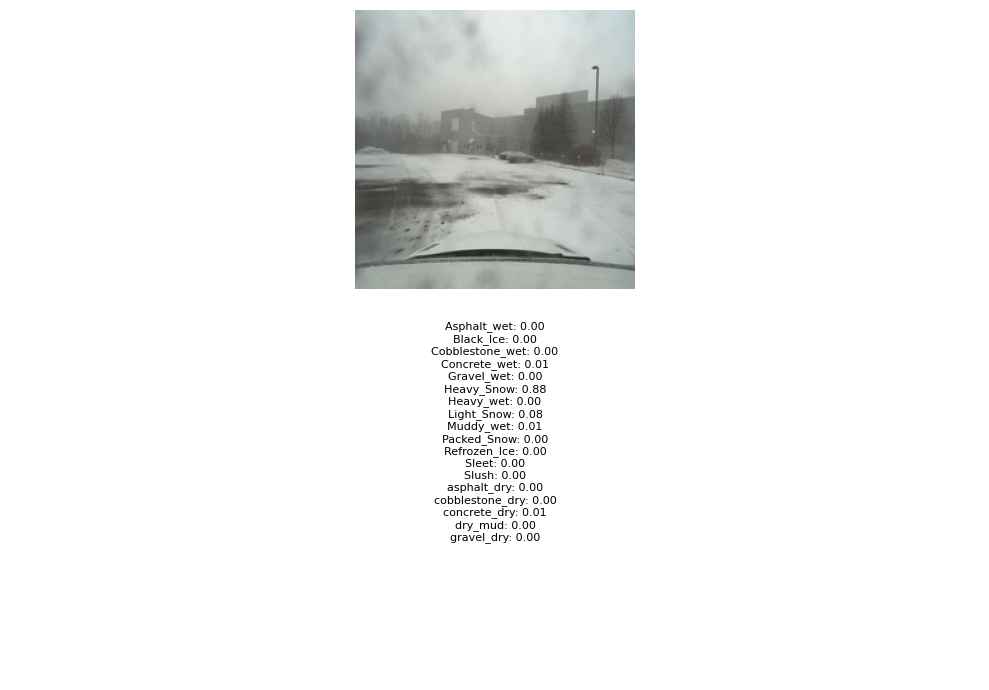

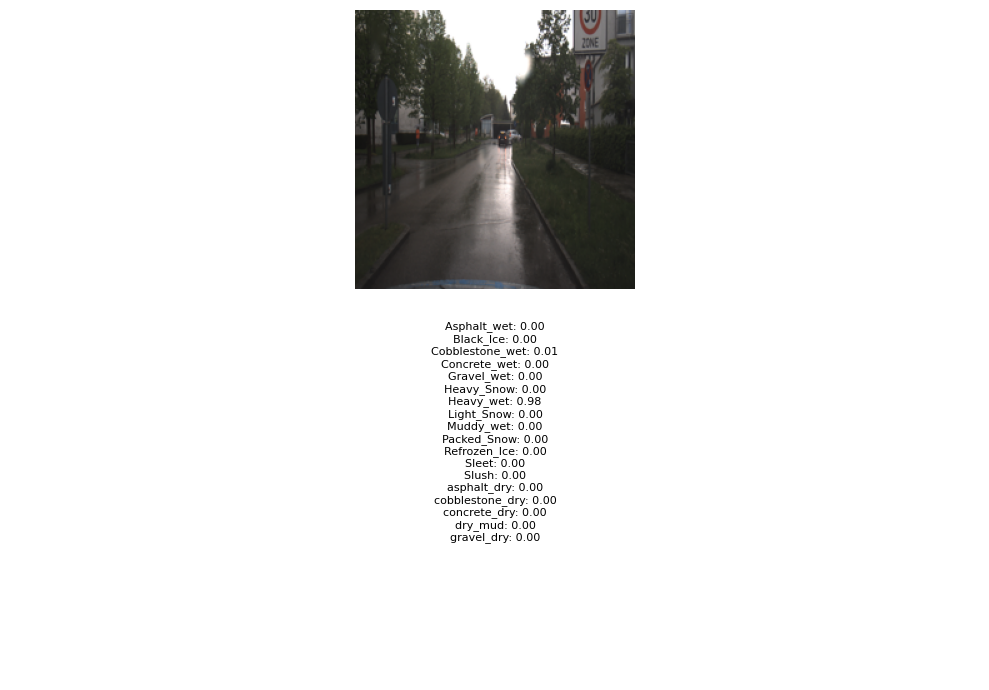

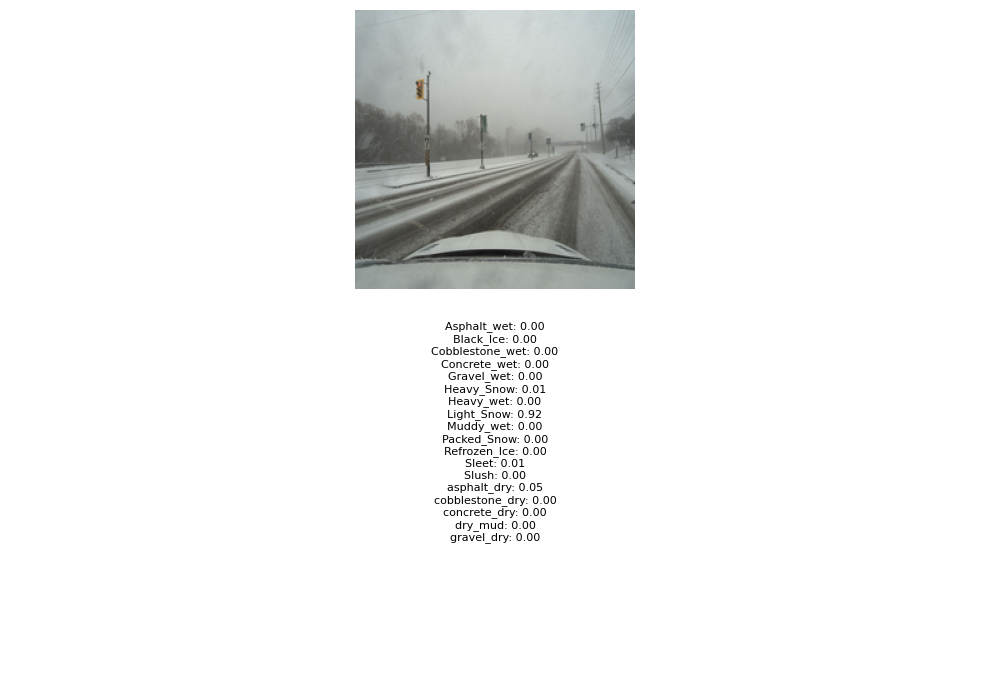

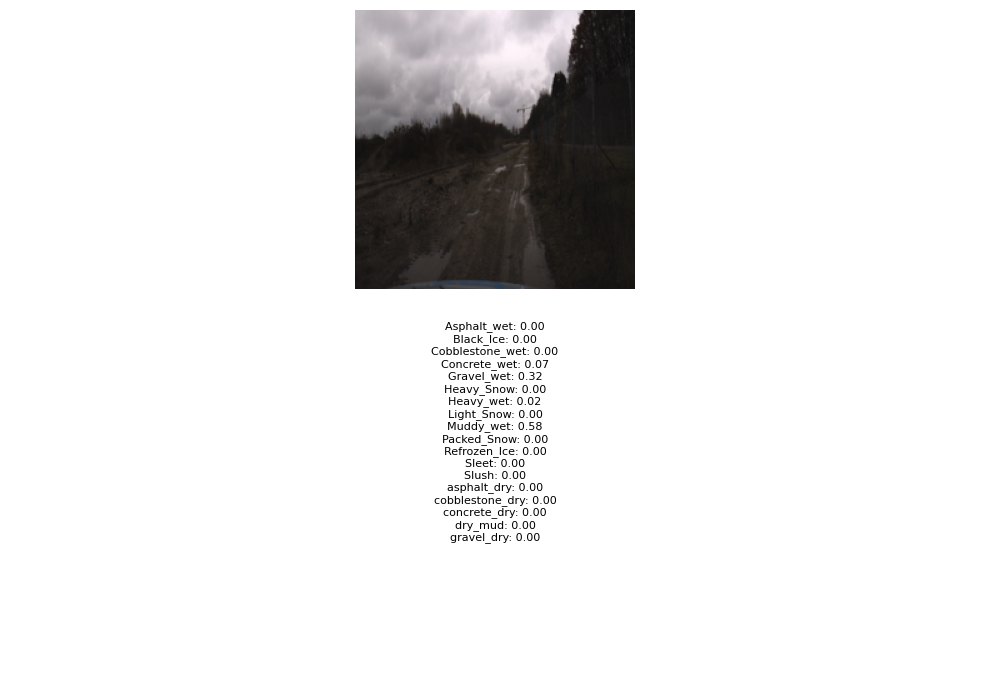

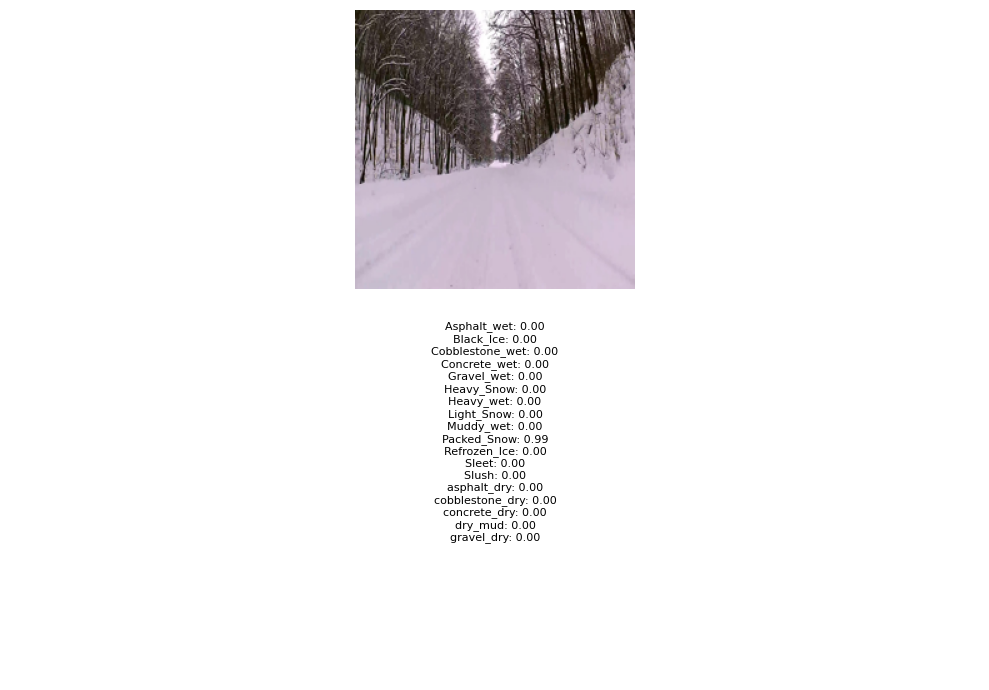

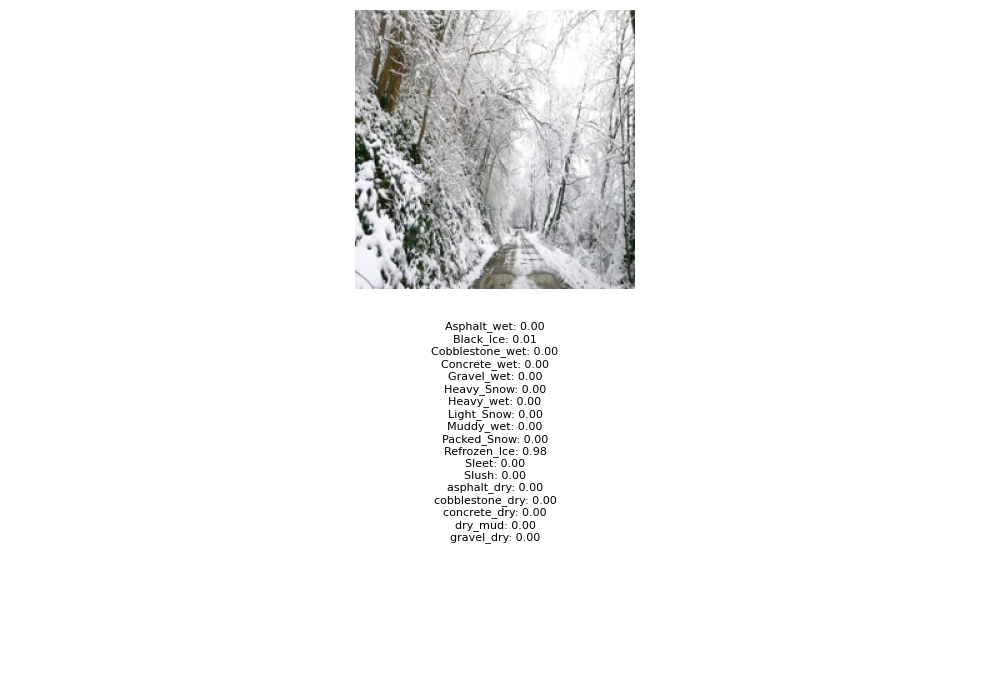

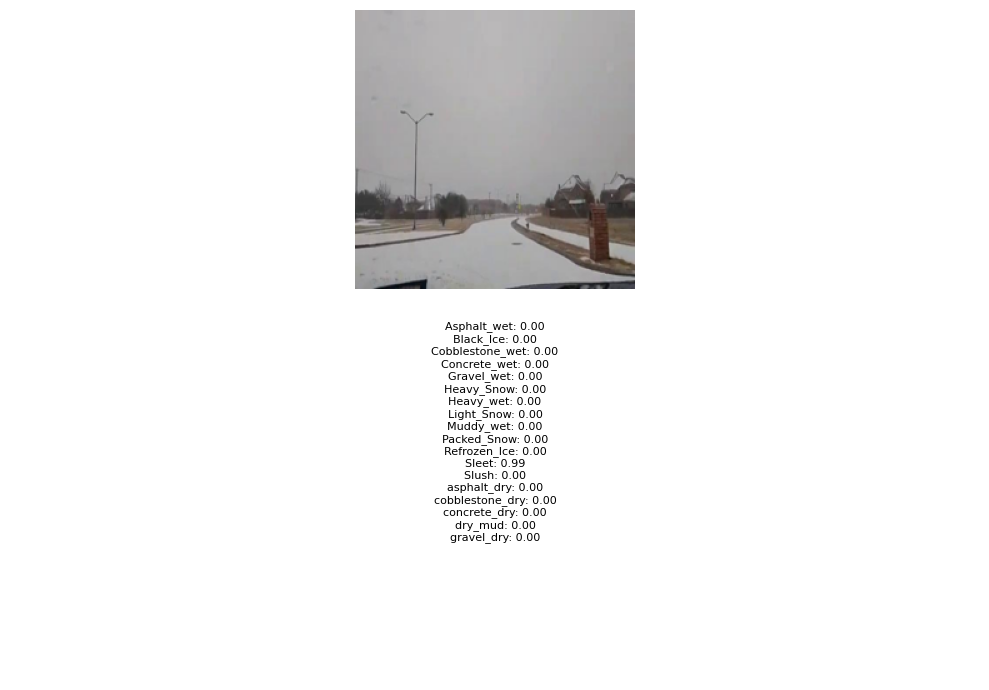

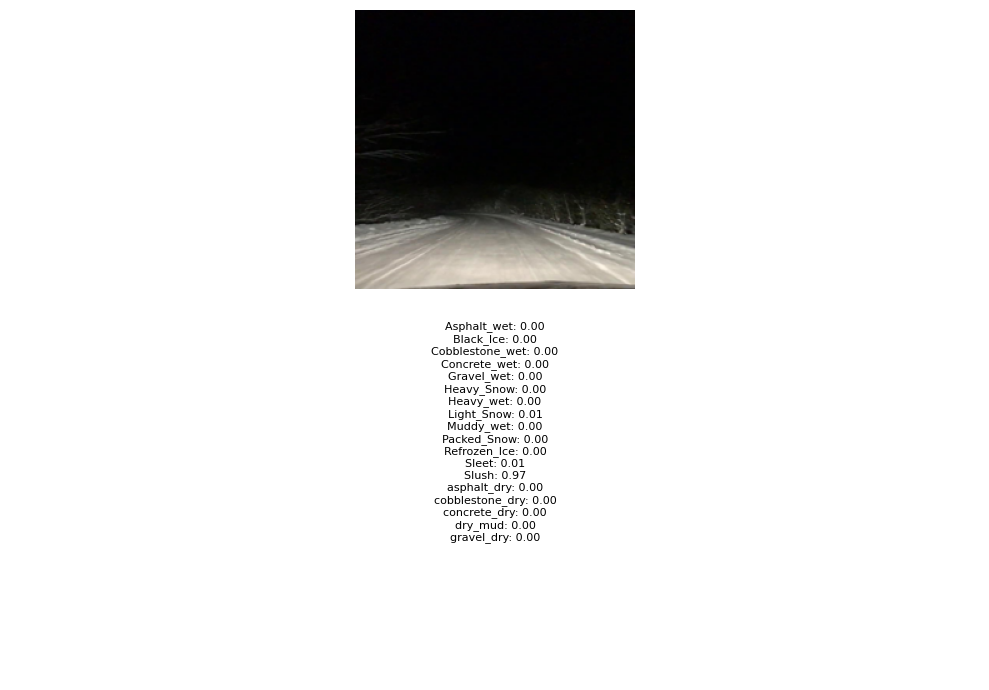

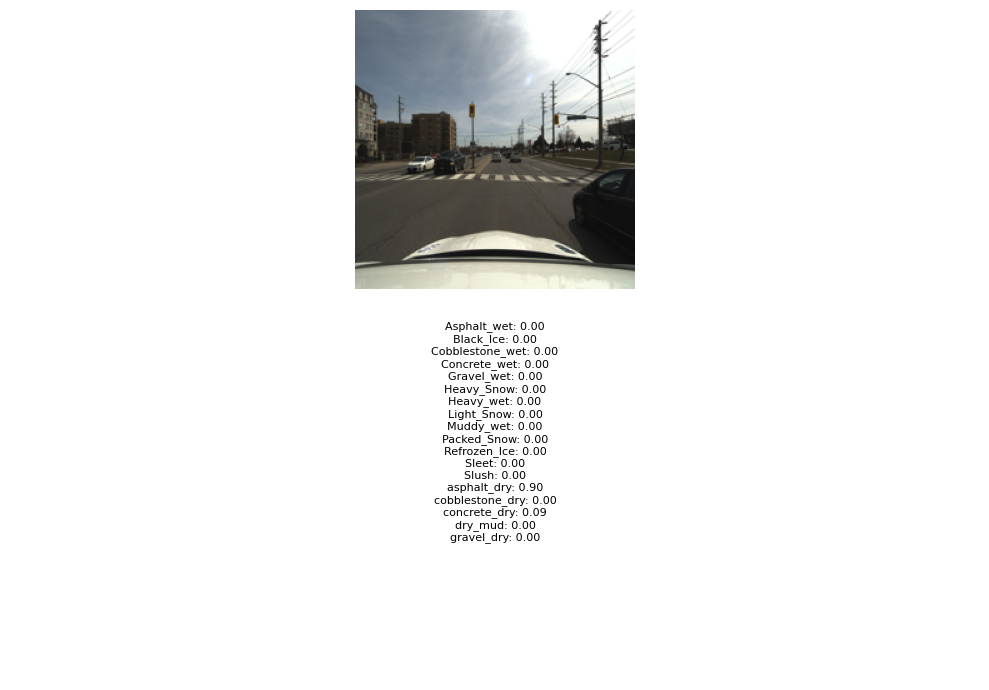

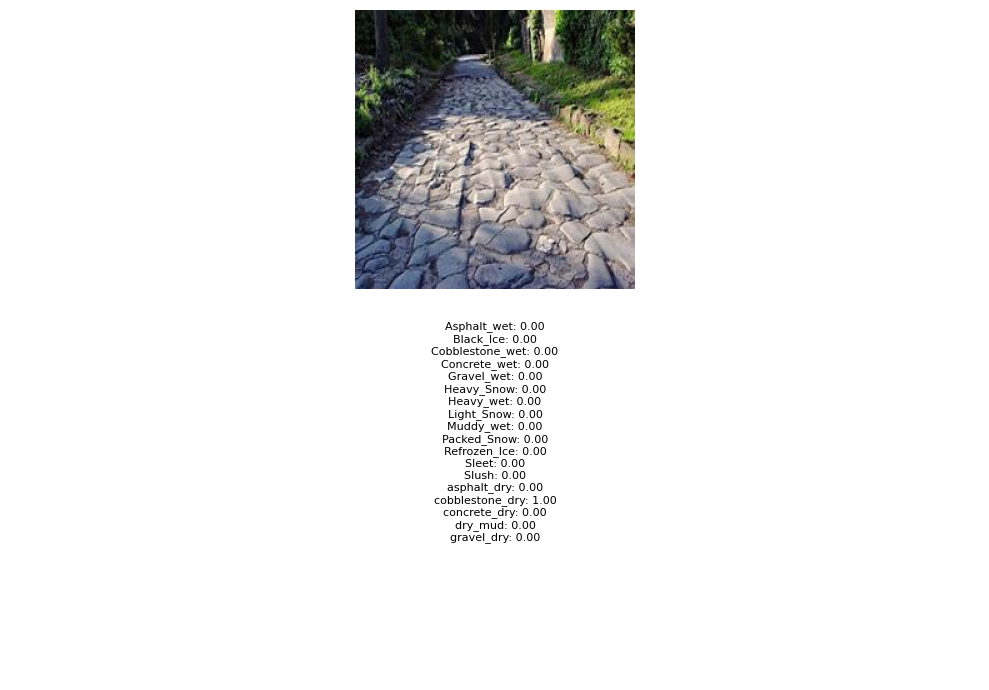

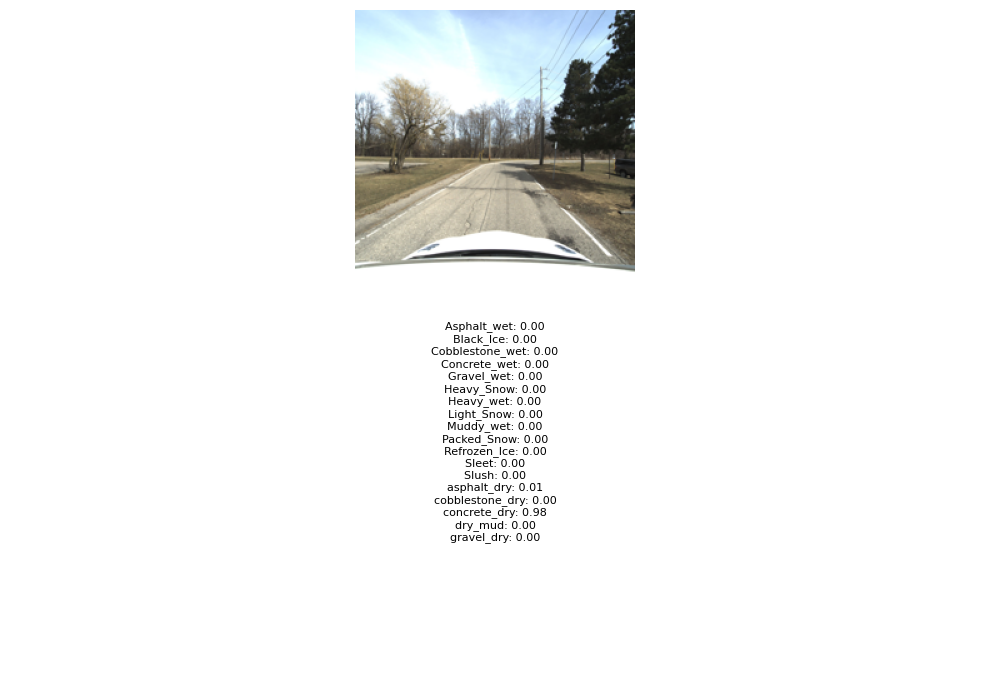

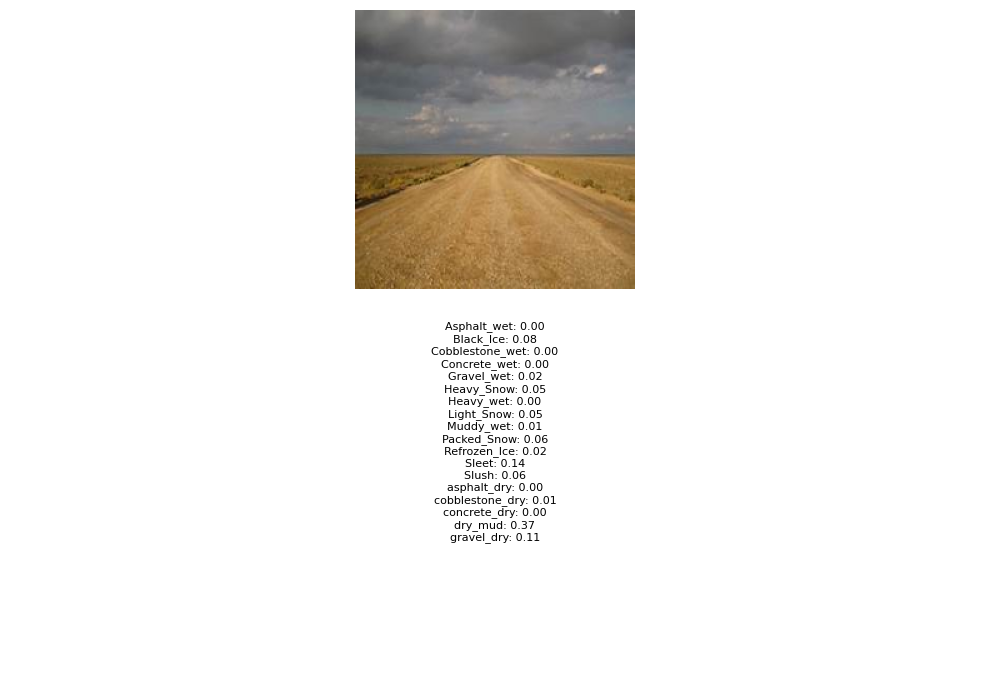

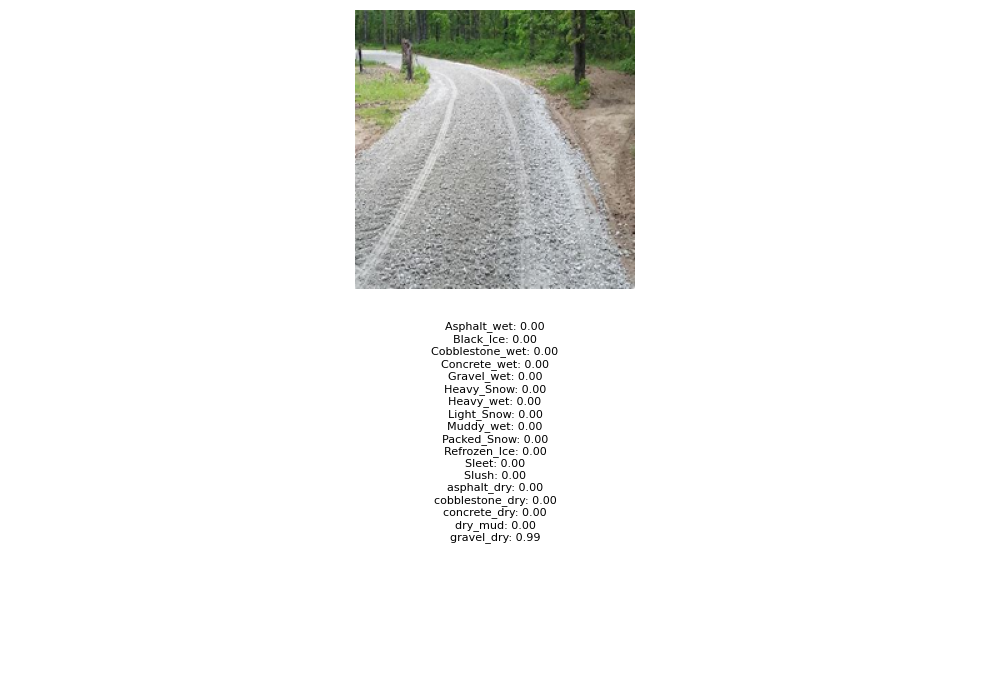

In [52]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

class_names = ['Asphalt_wet', 'Black_Ice','Cobblestone_wet','Concrete_wet','Gravel_wet','Heavy_Snow','Heavy_wet','Light_Snow','Muddy_wet','Packed_Snow','Refrozen_Ice',
               'Sleet','Slush','asphalt_dry','cobblestone_dry','concrete_dry','dry_mud','gravel_dry']
# Load the trained model
model = tf.keras.models.load_model('best_model_1024.keras')

# Load the test data
test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator)

# Iterate over each class
for i, class_name in enumerate(class_names):
    # Get the image paths for the current class
    class_image_paths = [path for path in test_generator.filepaths if class_name in path]

    # Get the first image path for the current class
    img_path = class_image_paths[0]

    # Create a figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
    ax2.axis('off')

    # Plot the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    ax1.imshow(img)

    # Get the prediction for the current image
    pred = predictions[test_generator.filepaths.index(img_path)]

    # Print the class probabilities
    text = '\n'.join([f"{class_names[class_index[0]]}: {prob:.2f}" for class_index, prob in np.ndenumerate(pred)])

    # Add text underneath the image
    ax2.text(0.5, 0.5, text, horizontalalignment='center', fontsize=8)
    ax1.axis('off')

    plt.tight_layout()
    plt.pause(0.001)

    # Close the figure after displaying
    plt.close(fig)
